## Segementing the squeak instances from the NIDQ stream

### One file example

In [9]:
from pathlib import Path
from spikeinterface.core import BinaryRecordingExtractor
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write as wavwrite
from scipy.signal import hilbert
import re
import os

seed = 42
np.random.seed(seed)

In [10]:
def read_spikeglx_meta(meta_path):
    meta = {}
    with open(meta_path, "r") as f:
        for line in f:
            if "=" in line:
                k, v = line.strip().split("=", 1)
                meta[k] = v
    return meta

bin_path = Path(r"J:\project_trainingAggression\Data\20250817_mouse975826\Day03\neuralData\catgt_20250818_m975826_obs2_g0\20250818_m975826_obs2_g0_tcat.nidq.bin")
meta = read_spikeglx_meta(bin_path.with_suffix(".meta"))

In [11]:
fs = float(meta["niSampRate"])
nch = int(meta["nSavedChans"])

rec = BinaryRecordingExtractor(
    file_paths=[bin_path],
    sampling_frequency=fs,
    num_channels=nch,
    dtype="int16",
)

rmax = float(meta.get("niAiRangeMax"))  
bitRes = float(meta.get("niMaxInt")) 

ch2 = rec.get_traces(channel_ids=[2]).squeeze()
ch2_v = ch2.astype("float32") * (rmax / bitRes) 

Detected 17 segments where envelope >= 0.25 V lasting >= 0.02s
Wrote: envelope_threshold_thr0.25V_min0.020s.wav  (duration 11.92s)


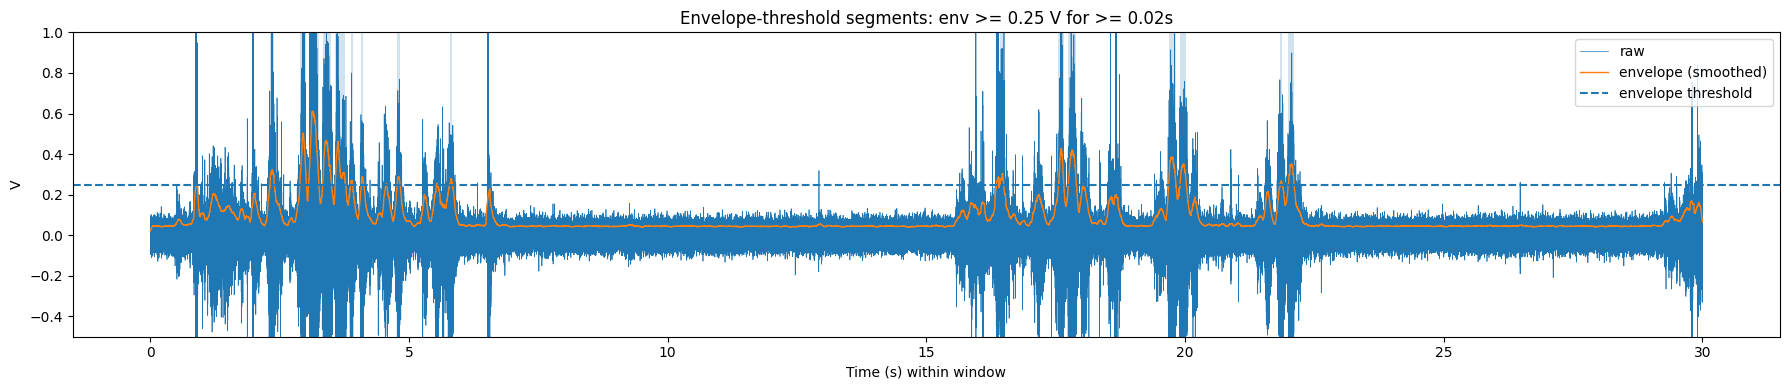

In [12]:
# --- Grab a window ---
start_frame = int(8 * 60 * fs)
end_frame   = int(8.5 * 60 * fs)
ch2 = rec.get_traces(start_frame=start_frame, end_frame=end_frame, channel_ids=[2]).squeeze()

# volts + DC remove
x = ch2.astype(np.float32) * (5.0 / 32768.0)
x -= x.mean()

# =========================
# Envelope threshold segmentation
# (envelope is always >= 0, so it accounts for both +/- swings)
# =========================
thr_v = 0.25      # threshold in "envelope volts"
min_dur_s = 0.02  # minimum segment duration (s)
min_len = int(min_dur_s * fs)

# --- Envelope (Hilbert) + smoothing ---
env = np.abs(hilbert(x))

def smooth(sig, win_s, fs):
    win = max(1, int(win_s * fs))
    k = np.ones(win, dtype=np.float32) / win
    return np.convolve(sig, k, mode="same")

env_s = smooth(env, win_s=0.075, fs=fs)  # 75 ms smoothing (moving average)

# Threshold on the envelope (not on |x|)
above = env_s >= thr_v

# --- Extract contiguous above-threshold segments ---
segments = []
i = 0
N = len(above)
while i < N:
    if above[i]:
        s = i
        while i < N and above[i]:
            i += 1
        e = i
        if (e - s) >= min_len:
            segments.append((s, e))
    else:
        i += 1

print(f"Detected {len(segments)} segments where envelope >= {thr_v} V lasting >= {min_dur_s}s")

# =========================
# Build concatenated audio for listening (from RAW x)
# =========================
pad_s = 0.05   # 10 ms padding
gap_s = 0.50   # 100 ms silence between segments
pad = int(pad_s * fs)
gap = np.zeros(int(gap_s * fs), dtype=np.float32)

clips = []
for s, e in segments:
    s0 = max(0, s - pad)
    e0 = min(len(x), e + pad)
    clips.append(x[s0:e0].astype(np.float32))
    clips.append(gap)

if clips:
    y = np.concatenate(clips)

    # normalize for listening
    peak = np.max(np.abs(y)) + 1e-12
    y_listen = (y / peak * 0.95).astype(np.float32)
    y_int16 = (y_listen * 32767).astype(np.int16)

    out_path = f"envelope_threshold_thr{thr_v:.2f}V_min{min_dur_s:.3f}s.wav"
    wavwrite(out_path, int(fs), y_int16)
    print(f"Wrote: {out_path}  (duration {len(y_int16)/fs:.2f}s)")
else:
    print("No segments found; no WAV written.")

# =========================
# Plot: raw + envelope + threshold + segments
# =========================
tvec = np.arange(len(x)) / fs

plt.figure(figsize=(18, 4))
plt.plot(tvec, x, linewidth=0.5, label="raw")
plt.plot(tvec, env_s, linewidth=1.0, label="envelope (smoothed)")
plt.axhline(thr_v, linestyle="--", label="envelope threshold")
for s, e in segments:
    plt.axvspan(tvec[s], tvec[e-1], alpha=0.2)

plt.title(f"Envelope-threshold segments: env >= {thr_v} V for >= {min_dur_s}s")
plt.xlabel("Time (s) within window")
plt.ylabel("V")
plt.legend(loc="upper right")
plt.ylim([-0.5,1])
plt.tight_layout()
plt.show()



### Applying to entire dataset

In [13]:

def env_thr_seg(x, fs, bin_path):
    """
    Envelope threshold segmentation (Hilbert envelope + smoothing).

    - Only considers segments at/after 5:45 (345 s).
    - Writes a concatenated WAV of detected segments (with padding + gaps).
    - Writes a Bento-style tab-delimited TXT next to the WAV with:
        start_sample, end_sample, duration_s
      where start/end are ABSOLUTE sample indices in the original x.
    """

    m = re.search(r"(\d{8}_m\d+_obs\d+)", bin_path.name)
    run_id = m.group(1) if m else bin_path.stem
    print(f"========== Session: {run_id} ==========")

    # =========================
    # PARAMETERS
    # =========================
    thr_v = 0.25       # threshold in "envelope volts"
    min_dur_s = 0.02   # minimum segment duration (s)
    min_len = int(min_dur_s * fs)

    # Only consider segments after 5 min 45 s
    t0_s = 5 * 60 + 45
    start_idx = int(t0_s * fs)

    # For concatenated "listening" WAV
    pad_s = 0.05   # 50 ms padding on each segment
    gap_s = 0.50   # 500 ms silence between segments
    pad = int(pad_s * fs)
    gap = np.zeros(int(gap_s * fs), dtype=np.float32)

    # =========================
    # ENVELOPE + SMOOTHING
    # =========================
    env = np.abs(hilbert(x.astype(np.float32)))

    def smooth(sig, win_s, fs_):
        win = max(1, int(win_s * fs_))
        k = np.ones(win, dtype=np.float32) / win
        return np.convolve(sig, k, mode="same")

    env_s = smooth(env, win_s=0.075, fs_=fs)  # 75 ms smoothing

    # Threshold on the envelope
    above = env_s >= thr_v

    # Enforce the 5:45 cutoff
    if start_idx > 0:
        above[:start_idx] = False

    # =========================
    # EXTRACT CONTIGUOUS SEGMENTS
    # =========================
    segments = []
    i = 0
    N = len(above)
    while i < N:
        if above[i]:
            s = i
            while i < N and above[i]:
                i += 1
            e = i
            if (e - s) >= min_len:
                segments.append((s, e))
        else:
            i += 1

    print(
        f"Detected {len(segments)} segments where envelope >= {thr_v} V "
        f"lasting >= {min_dur_s}s, after {t0_s}s"
    )

    # =========================
    # OUTPUT PATHS
    # =========================

    out_dir = bin_path.parent / "shallowSquaks"
    out_dir.mkdir(parents=True, exist_ok=True)

    wav_path = out_dir / f"{run_id}_segmentedSqueaks_thr_{thr_v:.2f}V_min{min_dur_s:.3f}s.wav"
    txt_path = wav_path.with_suffix(".txt")

    if not segments:
        print("No segments found; no WAV/TXT written.")
        return {
            "segments": [],
            "wav_path": None,
            "txt_path": None,
            "thr_v": thr_v,
            "min_dur_s": min_dur_s,
            "cutoff_s": t0_s,
        }

    # =========================
    # BUILD CONCATENATED WAV + COLLECT BENTO ROWS
    # =========================
    clips = []
    seg_rows = []  # list of (start_sample, end_sample) ABSOLUTE indices in x

    for (s, e) in segments:
        # padded clip bounds (for WAV only)
        s0 = max(0, s - pad)
        e0 = min(len(x), e + pad)

        clips.append(x[s0:e0].astype(np.float32))
        clips.append(gap)

        # Save unpadded detected bounds (absolute)
        seg_rows.append((s, e))

    y = np.concatenate(clips)

    # Normalize for listening and write WAV
    peak = np.max(np.abs(y)) + 1e-12
    y_listen = (y / peak * 0.95).astype(np.float32)
    y_int16 = (y_listen * 32767).astype(np.int16)

    wavwrite(str(wav_path), int(fs), y_int16)
    print(f"Wrote WAV: {wav_path}  (duration {len(y_int16)/fs:.2f}s)")

    # =========================
    # WRITE BENTO-STYLE TXT (TAB-DELIMITED)
    # =========================
    # start_sample <tab> end_sample <tab> duration_s
    with open(txt_path, "w", newline="\n") as f:
        f.write("start_sample\tend_sample\tduration_s\n")
        for s, e in seg_rows:
            dur_s = (e - s) / fs
            f.write(f"{s}\t{e}\t{dur_s:.6f}\n")

    print(f"Wrote TXT: {txt_path}  ({len(seg_rows)} calls)")

    return {
        "segments": seg_rows,
        "wav_path": str(wav_path),
        "txt_path": str(txt_path),
        "thr_v": thr_v,
        "min_dur_s": min_dur_s,
        "cutoff_s": t0_s,
    }


In [20]:
import numpy as np

call_counts = []
calls_per_min_list = []

for bin_path in ni_data:
    meta = read_spikeglx_meta(bin_path.with_suffix(".meta"))
    fs = float(meta["niSampRate"])
    nch = int(meta["nSavedChans"])
    rmax = float(meta.get("niAiRangeMax"))
    bitRes = float(meta.get("niMaxInt"))

    rec = BinaryRecordingExtractor(
        file_paths=[bin_path],
        sampling_frequency=fs,
        num_channels=nch,
        dtype="int16",
    )

    ch2 = rec.get_traces(channel_ids=[2]).squeeze()
    ch2_v = ch2.astype("float32") * (rmax / bitRes)

    data = env_thr_seg(ch2_v, fs, bin_path)

    n_calls = len(data["segments"])
    call_counts.append(n_calls)

    analyzed_s = (len(ch2_v) / fs) - data["cutoff_s"]
    calls_per_min = n_calls / (analyzed_s / 60.0) if analyzed_s > 0 else np.nan
    calls_per_min_list.append(calls_per_min)

call_counts = np.asarray(call_counts, dtype=float)
calls_per_min_arr = np.asarray(calls_per_min_list, dtype=float)

# mean/std (sample std via ddof=1)
mean_calls = np.nanmean(call_counts)
std_calls  = np.nanstd(call_counts, ddof=1) if np.sum(~np.isnan(call_counts)) > 1 else 0.0

mean_cpm = np.nanmean(calls_per_min_arr)
std_cpm  = np.nanstd(calls_per_min_arr, ddof=1) if np.sum(~np.isnan(calls_per_min_arr)) > 1 else 0.0

print(f"Sessions: {len(call_counts)}")
print(f"Calls/session: mean={mean_calls:.2f}, std={std_calls:.2f}")
print(f"Calls/min (post-cutoff): mean={mean_cpm:.3f}, std={std_cpm:.3f}")

    

========== Session: 20250817_m975826_obs1 ==========
Detected 22 segments where envelope >= 0.25 V lasting >= 0.02s, after 345s
Wrote WAV: J:\project_trainingAggression\Data\20250817_mouse975826\Day01\neuralData\catgt_20250817_m975826_obs1_g0\shallowSquaks\20250817_m975826_obs1_segmentedSqueaks_thr_0.25V_min0.020s.wav  (duration 14.89s)
Wrote TXT: J:\project_trainingAggression\Data\20250817_mouse975826\Day01\neuralData\catgt_20250817_m975826_obs1_g0\shallowSquaks\20250817_m975826_obs1_segmentedSqueaks_thr_0.25V_min0.020s.txt  (22 calls)
========== Session: 20250818_m975826_obs2 ==========
Detected 292 segments where envelope >= 0.25 V lasting >= 0.02s, after 345s
Wrote WAV: J:\project_trainingAggression\Data\20250817_mouse975826\Day03\neuralData\catgt_20250818_m975826_obs2_g0\shallowSquaks\20250818_m975826_obs2_segmentedSqueaks_thr_0.25V_min0.020s.wav  (duration 205.33s)
Wrote TXT: J:\project_trainingAggression\Data\20250817_mouse975826\Day03\neuralData\catgt_20250818_m975826_obs2_g0\s

In [24]:
from pathlib import Path
import re
import numpy as np
import pandas as pd

dt_folder = Path(r"J:\project_trainingAggression\Data")

Agg = ["975826", "975827", "975833", "978772", "988590", "1010820", "1010823", "1010826", "1029741"]
nonAgg = ["975830", "978774", "978775", "1010819", "997839", "997840", "997841", "1029736", "1029739", "1032216"] # 978775 mounts/light attacks on the last day of training
maladaptive = ["978513", "978527", "978528", "1010832", "1013590"]

GROUPS = {"Agg": Agg, "nonAgg": nonAgg, "maladaptive": maladaptive}

group_unit_probe = {g: [] for g in GROUPS}  # probe id per unit row (0/1/2)

OBS = "obs3"
T_BEFORE = 1
T_AFTER = 2.0
BIN_SIZE = 0.02
SELECTED_LABELS = {"good"}  # adjust if needed


# -----------------------------
# Helpers
# -----------------------------
def group_of_mouse(mid: str) -> str:
    if mid in Agg:
        return "Aggressor"
    if mid in nonAgg:
        return "Non-aggressor"
    if mid in maladaptive:
        return "Maladaptive"

def read_spikeglx_meta(meta_path: Path) -> dict:
    meta = {}
    for line in meta_path.read_text().splitlines():
        if "=" in line:
            k, v = line.split("=", 1)
            meta[k.strip()] = v.strip()
    return meta

def find_catgt_sessions(mouse_id: str, obs: str):
    return sorted([p for p in dt_folder.rglob(f"catgt_*_m{mouse_id}_{obs}_g*") if p.is_dir()])

def find_nidq_bin(catgt_folder: Path) -> Path | None:
    c = sorted(catgt_folder.glob("*_tcat.nidq.bin"))
    if c:
        return c[0]
    c = sorted(catgt_folder.glob("*.nidq.bin"))
    return c[0] if c else None

def find_squeak_txt(catgt_folder: Path) -> Path | None:
    sq_dir = catgt_folder / "shallowSquaks"
    if not sq_dir.exists():
        return None
    txts = sorted(sq_dir.glob("*segmentedSqueaks*.txt"))
    return txts[0] if txts else None

def load_event_times_sec(catgt_folder: Path) -> np.ndarray:
    nidq_bin = find_nidq_bin(catgt_folder)
    txt = find_squeak_txt(catgt_folder)
    if nidq_bin is None or txt is None:
        return np.array([], dtype=np.float64)

    meta = read_spikeglx_meta(nidq_bin.with_suffix(".meta"))
    fs_nidq = float(meta["niSampRate"])

    df = pd.read_csv(txt, sep=r"\s+", engine="python")
    start_samples = (
        df["start_sample"].to_numpy(np.int64)
        if "start_sample" in df.columns
        else df.iloc[:, 0].to_numpy(np.int64)
    )
    return (start_samples / fs_nidq).astype(np.float64)

def find_selection_dirs(catgt_folder: Path):
    """
    ONLY use autoForNeuroConcat folders that contain cluster_info.tsv or cluster_group.tsv.
    """
    sel_dirs = set()

    for p in catgt_folder.rglob("autoForNeuroConcat"):
        if not p.is_dir():
            continue
        if (p / "cluster_info.tsv").exists() or (p / "cluster_group.tsv").exists():
            sel_dirs.add(p)

    return sorted(sel_dirs)

def find_spike_dir_from(sel_dir: Path) -> Path | None:
    if (sel_dir / "spike_times.npy").exists() and (sel_dir / "spike_clusters.npy").exists():
        return sel_dir
    d = sel_dir
    for _ in range(10):
        if (d / "spike_times.npy").exists() and (d / "spike_clusters.npy").exists():
            return d
        d = d.parent
    return None

def read_kilosort_sample_rate(any_dir: Path) -> float:
    for d in [any_dir, any_dir.parent, any_dir.parent.parent]:
        p = d / "params.py"
        if p.exists():
            txt = p.read_text()
            m = re.search(r"sample_rate\s*=\s*([0-9.]+)", txt)
            if m:
                return float(m.group(1))
            m = re.search(r"sampling_rate\s*=\s*([0-9.]+)", txt)
            if m:
                return float(m.group(1))
    return 30000.0

def load_selected_cluster_ids(sel_dir: Path, selected_labels=SELECTED_LABELS) -> np.ndarray:
    cg = sel_dir / "cluster_group.tsv"
    ci = sel_dir / "cluster_info.tsv"

    if cg.exists():
        df = pd.read_csv(cg, sep="\t")
        if "cluster_id" in df.columns and "group" in df.columns:
            return df[df["group"].astype(str).isin(selected_labels)]["cluster_id"].to_numpy(dtype=np.int64)

    if ci.exists():
        df = pd.read_csv(ci, sep="\t")
        if "cluster_id" in df.columns and "KSLabel" in df.columns:
            return df[df["KSLabel"].astype(str).isin(selected_labels)]["cluster_id"].to_numpy(dtype=np.int64)
        if "cluster_id" in df.columns and "group" in df.columns:
            return df[df["group"].astype(str).isin(selected_labels)]["cluster_id"].to_numpy(dtype=np.int64)

    return np.array([], dtype=np.int64)

def load_spikes_by_unit(spike_dir: Path, fs_imec: float, selected_units: np.ndarray):
    st_path = spike_dir / "spike_times.npy"
    sc_path = spike_dir / "spike_clusters.npy"
    if not (st_path.exists() and sc_path.exists()):
        return {}

    spike_times = np.load(st_path).astype(np.int64).squeeze()
    spike_clusters = np.load(sc_path).astype(np.int64).squeeze()

    out = {}
    for uid in selected_units:
        mask = (spike_clusters == uid)
        if np.any(mask):
            out[int(uid)] = np.sort(spike_times[mask]).astype(np.float64) / fs_imec
    return out

def probe_id_from_path(p: Path) -> int | None:
    s = str(p).lower()
    if "imec0" in s or "probe0" in s:
        return 0
    if "imec1" in s or "probe1" in s:
        return 1
    if "imec2" in s or "probe2" in s:
        return 2
    return None

def compute_psth(spike_times_sec, event_times_sec, t_before, t_after, bin_size):
    edges = np.arange(-t_before, t_after + bin_size, bin_size)
    centers = (edges[:-1] + edges[1:]) / 2

    if event_times_sec.size == 0 or spike_times_sec.size == 0:
        return centers, np.zeros_like(centers)

    counts = np.zeros(edges.size - 1, dtype=np.int64)
    st = spike_times_sec

    for t0 in event_times_sec:
        lo = t0 - t_before
        hi = t0 + t_after
        i0 = np.searchsorted(st, lo, side="left")
        i1 = np.searchsorted(st, hi, side="right")
        rel = st[i0:i1] - t0
        c, _ = np.histogram(rel, bins=edges)
        counts += c

    fr = counts / (event_times_sec.size * bin_size)
    return centers, fr


# -----------------------------
# Compute (unchanged, + prints)  + PROBE TRACKING
# -----------------------------
edges = np.arange(-T_BEFORE, T_AFTER + BIN_SIZE, BIN_SIZE)
bin_centers = (edges[:-1] + edges[1:]) / 2
baseline_mask = (bin_centers >= -T_BEFORE) & (bin_centers < 0)
response_mask = (bin_centers >= 0) & (bin_centers < 0.2)

group_unit_fr = {g: [] for g in GROUPS}
group_unit_probe = {g: [] for g in GROUPS}   # <-- NEW: probe id per unit row (0/1/2)
group_n_units = {g: 0 for g in GROUPS}
group_n_events = {g: 0 for g in GROUPS}

for group_name, mice in GROUPS.items():
    for mouse_id in mice:
        grp_label = group_of_mouse(mouse_id)
        sessions = find_catgt_sessions(mouse_id, OBS)

        if not sessions:
            print(f"[MISS] {grp_label:13s} | mouse {mouse_id} | {OBS} | no catgt sessions found")
            continue

        for catgt_folder in sessions:
            event_times_sec = load_event_times_sec(catgt_folder)
            n_events = int(event_times_sec.size)

            if n_events == 0:
                print(f"[SKIP] {grp_label:13s} | mouse {mouse_id} | {OBS} | 0 squeaks | {catgt_folder}")
                continue

            group_n_events[group_name] += n_events

            sel_dirs = find_selection_dirs(catgt_folder)
            if not sel_dirs:
                print(f"[SKIP] {grp_label:13s} | mouse {mouse_id} | {OBS} | squeaks={n_events:4d} | NO cluster TSVs | {catgt_folder}")
                continue

            print(f"[READ] {grp_label:13s} | mouse {mouse_id} | {OBS} | squeaks={n_events:4d} | sel_dirs={len(sel_dirs):2d} | {catgt_folder}")

            session_units_added = 0

            for sel_dir in sel_dirs:
                # --- NEW: determine probe id once per selection dir ---
                probe_id = probe_id_from_path(sel_dir)
                if probe_id is None:
                    probe_id = -1  # unknown

                selected_units = load_selected_cluster_ids(sel_dir, selected_labels=SELECTED_LABELS)
                if selected_units.size == 0:
                    print(f"       - sel_dir: {sel_dir} | selected_units=0 (labels={SELECTED_LABELS})")
                    continue

                spike_dir = find_spike_dir_from(sel_dir)
                if spike_dir is None:
                    print(f"       - sel_dir: {sel_dir} | selected_units={selected_units.size:4d} | NO spike_times.npy found")
                    continue

                fs_imec = read_kilosort_sample_rate(spike_dir)
                spikes_by_unit = load_spikes_by_unit(spike_dir, fs_imec, selected_units)
                if not spikes_by_unit:
                    print(f"       - sel_dir: {sel_dir} | selected_units={selected_units.size:4d} | spike_dir={spike_dir} | 0 units w/ spikes")
                    continue

                n_units_here = len(spikes_by_unit)
                print(f"       - sel_dir: {sel_dir} | selected_units={selected_units.size:4d} | loaded_units={n_units_here:4d} | probe={probe_id} | spike_dir={spike_dir}")

                for uid, st_sec in spikes_by_unit.items():
                    _, fr = compute_psth(st_sec, event_times_sec, T_BEFORE, T_AFTER, BIN_SIZE)

                    # --- append unit row + its probe id ---
                    group_unit_fr[group_name].append(fr)
                    group_unit_probe[group_name].append(probe_id)

                    group_n_units[group_name] += 1
                    session_units_added += 1

            print(f"       -> session total units added: {session_units_added}\n")

# Build matrices + baseline-subtract per unit (unchanged)
group_unit_matrix_bl = {}
group_unit_order = {}
group_mean_fr_bl = {}

for g in GROUPS:
    if len(group_unit_fr[g]) == 0:
        group_unit_matrix_bl[g] = np.zeros((0, bin_centers.size), dtype=np.float64)
        group_unit_order[g] = np.array([], dtype=np.int64)
        group_mean_fr_bl[g] = np.zeros_like(bin_centers, dtype=np.float64)
        continue

    M = np.vstack(group_unit_fr[g])
    M_bl = M - M[:, baseline_mask].mean(axis=1, keepdims=True)

    score = M_bl[:, response_mask].mean(axis=1)
    order = np.argsort(score)[::-1]

    group_unit_matrix_bl[g] = M_bl
    group_unit_order[g] = order
    group_mean_fr_bl[g] = M_bl.mean(axis=0)

print("Done.")
print("Units:", group_n_units)
print("Events:", group_n_events)

[READ] Aggressor     | mouse 975826 | obs3 | squeaks= 105 | sel_dirs= 3 | J:\project_trainingAggression\Data\20250817_mouse975826\Day05\neuralData\catgt_20250818_m975826_obs3_g0
       - sel_dir: J:\project_trainingAggression\Data\20250817_mouse975826\Day05\neuralData\catgt_20250818_m975826_obs3_g0\20250818_m975826_obs3_g0_imec0\Kilosort4_probe0\sorter_output\autoForNeuroConcat | selected_units=  28 | loaded_units=  28 | probe=0 | spike_dir=J:\project_trainingAggression\Data\20250817_mouse975826\Day05\neuralData\catgt_20250818_m975826_obs3_g0\20250818_m975826_obs3_g0_imec0\Kilosort4_probe0\sorter_output
       - sel_dir: J:\project_trainingAggression\Data\20250817_mouse975826\Day05\neuralData\catgt_20250818_m975826_obs3_g0\20250818_m975826_obs3_g0_imec1\Kilosort4_probe1\sorter_output\autoForNeuroConcat | selected_units=  58 | loaded_units=  58 | probe=1 | spike_dir=J:\project_trainingAggression\Data\20250817_mouse975826\Day05\neuralData\catgt_20250818_m975826_obs3_g0\20250818_m975826_o

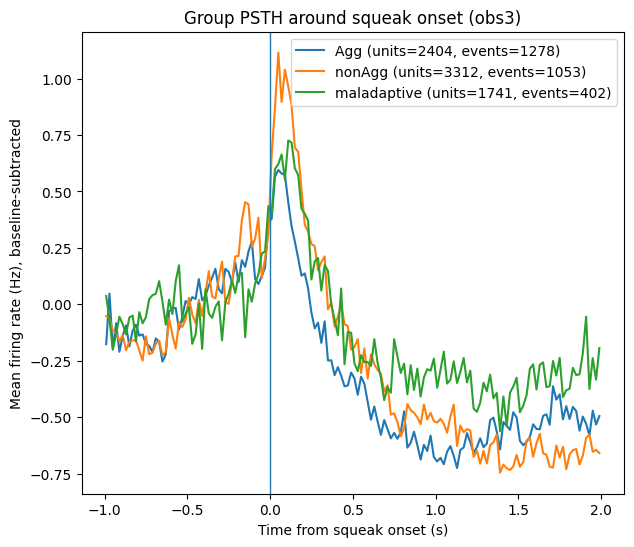

In [31]:
plt.figure(figsize = (7,6))
for g in GROUPS:
    plt.plot(
        bin_centers,
        group_mean_fr_bl[g],
        label=f"{g} (units={group_n_units[g]}, events={group_n_events[g]})"
    )

plt.axvline(0, linewidth=1)
plt.xlabel("Time from squeak onset (s)")
plt.ylabel("Mean firing rate (Hz), baseline-subtracted")
plt.title(f"Group PSTH around squeak onset ({OBS})")
plt.legend()
plt.show()


Agg {0: 512, 1: 702, 2: 1190}
nonAgg {0: 543, 1: 1430, 2: 1339}
maladaptive {0: 363, 1: 687, 2: 691}


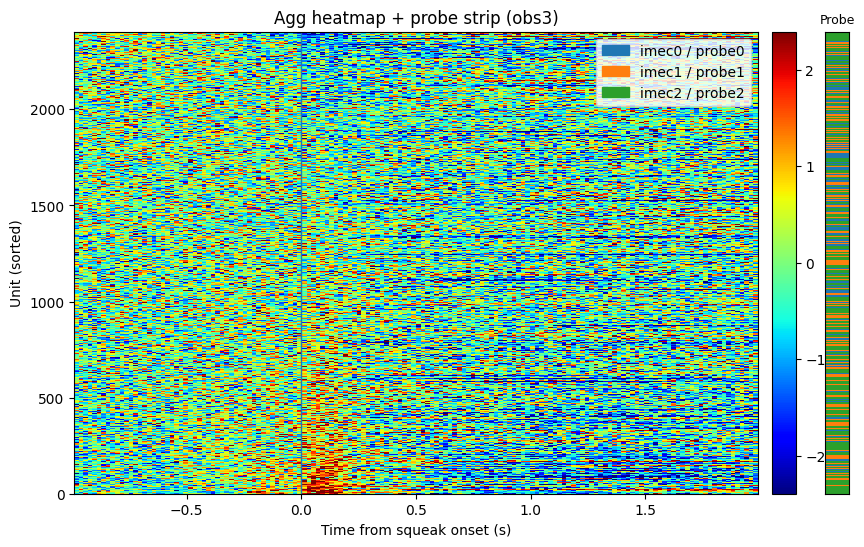

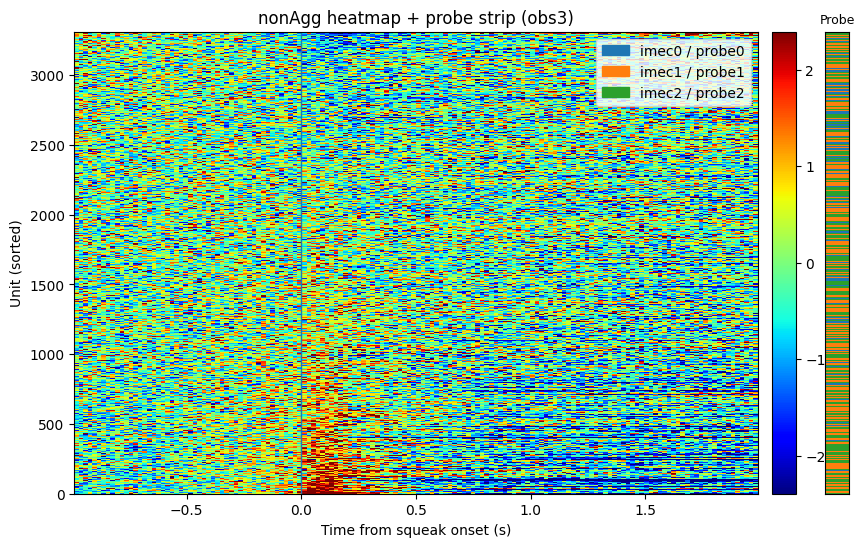

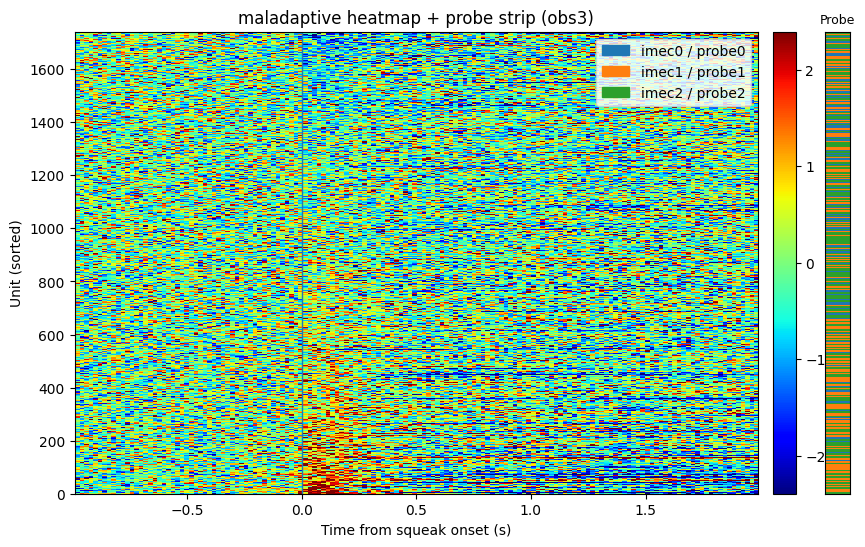

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

probe_cmap = ListedColormap(["tab:blue", "tab:orange", "tab:green"])  # 0/1/2

def plot_heatmap_with_probe_strip(Z, order, probe_ids, bin_centers, title,
                                  vmin=None, vmax=None, cmap="jet"):
    if Z.shape[0] == 0:
        print("No units for:", title)
        return

    Zs = Z[order, :]
    probes_sorted = np.asarray(probe_ids, dtype=int)[order]

    # strip image (n_units, 1)
    strip_vals = probes_sorted.copy()
    strip_vals[strip_vals < 0] = 0
    strip_img = strip_vals[:, None]

    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=[30, 1], wspace=0.05)

    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(
        Zs,
        aspect="auto",
        origin="lower",
        interpolation="nearest",
        extent=[bin_centers[0], bin_centers[-1], 0, Zs.shape[0]],
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
    )
    ax.axvline(0, linewidth=1)
    ax.set_xlabel("Time from squeak onset (s)")
    ax.set_ylabel("Unit (sorted)")
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    cbar.set_label("Z (baseline-normalized)")

    ax_strip = fig.add_subplot(gs[0, 1])
    ax_strip.imshow(strip_img, aspect="auto", origin="lower",
                    interpolation="nearest", cmap=probe_cmap, vmin=0, vmax=2)
    ax_strip.set_xticks([])
    ax_strip.set_yticks([])
    ax_strip.set_title("Probe", fontsize=9)

    handles = [
        mpatches.Patch(color="tab:blue", label="imec0 / probe0"),
        mpatches.Patch(color="tab:orange", label="imec1 / probe1"),
        mpatches.Patch(color="tab:green", label="imec2 / probe2"),
    ]
    ax.legend(handles=handles, loc="upper right", frameon=True)

    plt.show()


# ---- Build Z + order DIRECTLY from group_unit_fr + group_unit_probe (guaranteed aligned) ----
resp = (0, 0.2)
baseline_mask = (bin_centers >= -T_BEFORE) & (bin_centers < 0)
resp_mask = (bin_centers >= resp[0]) & (bin_centers < resp[1])

# Global vmin/vmax for consistent scaling across groups (robust)
allZ_list = []

Z_by_group = {}
order_by_group = {}

for g in GROUPS:
    if len(group_unit_fr[g]) == 0:
        Z_by_group[g] = np.zeros((0, len(bin_centers)))
        order_by_group[g] = np.array([], dtype=int)
        continue

    # alignment check
    assert len(group_unit_fr[g]) == len(group_unit_probe[g]), \
        f"Mismatch for {g}: fr rows={len(group_unit_fr[g])} vs probe rows={len(group_unit_probe[g])}"

    M_raw = np.vstack(group_unit_fr[g])  # Hz

    # z-score per unit using baseline
    bl_mean = M_raw[:, baseline_mask].mean(axis=1, keepdims=True)
    bl_std  = M_raw[:, baseline_mask].std(axis=1, keepdims=True)
    bl_std  = np.where(bl_std < 1e-6, 1e-6, bl_std)
    Z = (M_raw - bl_mean) / bl_std

    # sort by mean Z in response window (same Z we plot)
    score = Z[:, resp_mask].mean(axis=1)
    order = np.argsort(score)[::-1]

    Z_by_group[g] = Z
    order_by_group[g] = order

    allZ_list.append(Z.ravel())

allZ = np.concatenate(allZ_list) if allZ_list else np.array([0.0])
vmin, vmax = np.percentile(allZ, [2, 98])
m = max(abs(vmin), abs(vmax))
vmin, vmax = -m, m

# Quick probe sanity print
for g in GROUPS:
    probes = np.asarray(group_unit_probe[g], dtype=int)
    if probes.size:
        u, c = np.unique(probes, return_counts=True)
        print(g, dict(zip(u.tolist(), c.tolist())))

# Plot
for g in GROUPS:
    plot_heatmap_with_probe_strip(
        Z_by_group[g],
        order_by_group[g],
        group_unit_probe[g],
        bin_centers,
        title=f"{g} heatmap + probe strip ({OBS})",
        vmin=vmin, vmax=vmax, cmap="jet"
    )
